## Data Loading and Initial Challenges
Initially, we faced a challenge fetching the dataset directly using the `ucimlrepo` library due to server-side connectivity issues.

To overcome this, we adopted an alternative approach by manually downloading the `chronic_kidney_disease_full.arff` file. We then implemented a custom parsing script, adapted from a solution on [Stack Overflow](https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io/66939746#66939746), to load the data into a pandas DataFrame.

The script reads the .arff file line by line, skipping the header metadata and using a predefined list of column names to structure the data correctly. The code for this process is as follows:

In [364]:
import pandas as pd

data = []
with open('kidney/chronic_kidney_disease_full.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class', 'no_name']

df = pd.DataFrame(data[145:], columns=names)
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
count,402,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,3
unique,78,11,6,7,7,3,3,3,3,147,...,93,50,3,7,4,4,4,3,4,2
top,60,80,1.020,0,0,normal,normal,notpresent,notpresent,?,...,?,?,no,no,no,good,no,no,ckd,
freq,19,116,106,199,290,201,259,354,374,44,...,105,130,251,257,362,316,322,339,248,2


## Feature Selection and Data Type Conversion

Our manual loading method didn't preserve the original data types, however, this was not a significant issue, as our plan from the start was to focus mainly on the numeric features for this analysis.

In [365]:
df.dtypes

age        object
bp         object
sg         object
al         object
su         object
rbc        object
pc         object
pcc        object
ba         object
bgr        object
bu         object
sc         object
sod        object
pot        object
hemo       object
pcv        object
wbcc       object
rbcc       object
htn        object
dm         object
cad        object
appet      object
pe         object
ane        object
class      object
no_name    object
dtype: object


First, we will drop the categorical columns that aren't needed for this analysis. Then, we'll convert the remaining columns using the to_numeric function in pandas. We use the errors='coerce' setting, which is very helpful because it automatically turns any value that can't be converted (like a leftover symbol or text) into NaN (Not a Number). This makes the entire dataset consistent and easier to clean in the next steps.

#### 1. Feature Selection: Drop unnecessary categorical and identifier columns

In [366]:
df = df.drop(columns=[
    'no_name', 'rbc', 'pc', 'pcc', 'ba',
    'sc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'
])

#### 2. Data Type Conversion: Define which columns should be numeric

In [367]:
numeric_cols = ['age', 'bp', 'sg', 'al', 'su',
                'bgr', 'bu', 'sod', 'pot', 'hemo',
                'pcv', 'wbcc', 'rbcc']

# Loop through the list and convert each column
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#### 3. Verification: Display the final data types to confirm the conversion

In [368]:
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
bgr      float64
bu       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
class     object
dtype: object

## Data cleaning

After loading and formatting the data, the next critical phase is data cleaning. The primary goals for this stage are to handle the missing values, simplify the class column for modeling, and identify any potential outliers that could affect the results.

Our cleaning process consists of the following steps:
#### 1. Standardize Missing Values
Ensure all placeholders are consistently represented as `NaN`.

In [369]:
# Note: pd.to_numeric with errors='coerce' already handled most of this.
# This is an extra step to ensure consistency.
df = df.replace(['?', 'None'], pd.NA)

#### 2. Handle Rows with Missing Data:
Remove rows that have an excessive number of missing values (3 or more), as they are unlikely to be useful.

In [370]:
df = df.dropna(thresh=len(df.columns)-2)
df = df.reset_index(drop=True)

#### 3. Impute Remaining Missing Values:
Fill the few remaining NaNs in the numeric columns. We will use the mean of each column for this.

In [371]:
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean()).round(3)

#### 4. Encode the Target Variable:
Simplify the class column into two distinct categories for our analysis.

In [372]:
#Changing ckd --> a (affected), notckd && no --> c (control)
df['class'] = df['class'].replace({'ckd': 'a', 'notckd': 'c', 'no': 'c'})

#### 5. Verify that there are no missing values left

In [373]:
print("\nTotal missing values per column after cleaning:\n")
print(df.isnull().sum())


Total missing values per column after cleaning:

age      0
bp       0
sg       0
al       0
su       0
bgr      0
bu       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
class    0
dtype: int64


In [374]:
print("\nDataFrame after cleaning and imputation:\n")
display(df.head())


DataFrame after cleaning and imputation:



,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,138.193,4.52,15.4,44.0,7800.000,5.200,a
1,48.0,70.0,1.005,4.0,0.0,117.0,56.0,111.000,2.50,11.2,32.0,6700.000,3.900,a
2,51.0,80.0,1.010,2.0,0.0,106.0,26.0,138.193,4.52,11.6,35.0,7300.000,4.600,a
3,60.0,90.0,1.015,3.0,0.0,74.0,25.0,142.000,3.20,12.2,39.0,7800.000,4.400,a
4,68.0,70.0,1.010,0.0,0.0,100.0,54.0,104.000,4.00,12.4,36.0,8498.795,4.759,a


## Final Data Preparation for Analysis

With the data now cleaned and validated, we perform the final preparation steps required by the assignment. This involves a unit conversion for the hemoglobin feature, renaming the columns for better readability and finally splitting the dataset into two groups—affected patients and a control group—for comparative analysis.

#### 1. Hemoglobin Unit Conversion
The original dataset measures hemoglobin in grams per deciliter (g/dl). The assignment requires this to be in grams per liter (g/l). We perform this conversion by multiplying the entire hemoglobin column by 10.

In [375]:
df['hemo'] = pd.to_numeric(df['hemo'], errors='coerce') * 10
df

,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,138.193,4.52,154.0,44.0,7800.000,5.200,a
1,48.0,70.0,1.005,4.0,0.0,117.0,56.0,111.000,2.50,112.0,32.0,6700.000,3.900,a
2,51.0,80.0,1.010,2.0,0.0,106.0,26.0,138.193,4.52,116.0,35.0,7300.000,4.600,a
3,60.0,90.0,1.015,3.0,0.0,74.0,25.0,142.000,3.20,122.0,39.0,7800.000,4.400,a
4,68.0,70.0,1.010,0.0,0.0,100.0,54.0,104.000,4.00,124.0,36.0,8498.795,4.759,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,55.0,80.0,1.020,0.0,0.0,140.0,49.0,150.000,4.90,157.0,47.0,6700.000,4.900,c
261,42.0,70.0,1.025,0.0,0.0,75.0,31.0,141.000,3.50,165.0,54.0,7800.000,6.200,c
262,12.0,80.0,1.020,0.0,0.0,100.0,26.0,137.000,4.40,158.0,49.0,6600.000,5.400,c
263,17.0,60.0,1.025,0.0,0.0,114.0,50.0,135.000,4.90,142.0,51.0,7200.000,5.900,c


#### 2. Renaming Columns for Clarity
As an important step for readability, especially for the upcoming graphs and analysis, we first convert the abbreviated column names into more descriptive ones.

In [376]:
column_name_map = {
    'age': 'age',
    'bp': 'blood_pressure',
    'sg': 'specific_gravity',
    'al': 'albumin',
    'su': 'sugar',
    'bgr': 'blood_glucose_random',
    'bu': 'blood_urea',
    'sod': 'sodium',
    'pot': 'potassium',
    'hemo': 'hemoglobin',
    'pcv': 'packed_cell_volume',
    'wbcc': 'white_blood_cell_count', # From your screenshot
    'rbcc': 'red_blood_cell_count',   # From your screenshot
    'class': 'class'
}
df_renamed = df.rename(columns=column_name_map)

#### 3. Splitting Dataframe by Class
To analyze the differences between patients with Chronic Kidney Disease and the control group, we now split the main DataFrame into two separate ones based on the 'class' column: df_a for affected patients and df_c for the control group.

In [377]:
# Using .copy() is a good practice to prevent potential warnings from pandas
df_a = df_renamed[df_renamed['class'] == 'a'].copy()
df_c = df_renamed[df_renamed['class'] == 'c'].copy()

# Verify the split by printing the number of rows in each new DataFrame
print(f"\nNumber of rows in Affected group (df_a): {df_a.shape[0]}")
print(f"Number of rows in Control group (df_c): {df_c.shape[0]}")


Number of rows in Affected group (df_a): 126
Number of rows in Control group (df_c): 139


#### 4. Comparing Group Statistics
Finally, we generate descriptive statistics for both groups. This gives us an initial quantitative overview of their characteristics and allows us to see potential differences at a glance.

In [378]:
# Generate and display statistics for the 'affected' group
print("\n--- Statistics for Affected Group (a) ---")
display(df_a.describe().T)

# Generate and display statistics for the 'control' group
print("\n--- Statistics for Control Group (c) ---")
display(df_c.describe().T)

# Using .T (transpose) to make the table easier to read if there are many columns


--- Statistics for Affected Group (a) ---


,count,mean,std,min,25%,50%,75%,max
age,126.0,56.948508,14.315945,6.000,50.000,60.000,65.00000,90.000
blood_pressure,126.0,80.680968,15.712210,50.000,70.000,80.000,90.00000,180.000
specific_gravity,126.0,1.013595,0.004526,1.005,1.010,1.015,1.01500,1.025
albumin,126.0,1.849206,1.437038,0.000,0.250,2.000,3.00000,5.000
sugar,126.0,0.809524,1.366539,0.000,0.000,0.000,1.00000,5.000
blood_glucose_random,126.0,179.339143,91.658210,22.000,108.250,147.000,238.75000,490.000
blood_urea,126.0,80.224071,60.298976,1.500,37.500,59.000,106.75000,322.000
sodium,126.0,134.368841,7.264335,104.000,132.000,136.000,138.19300,145.000
potassium,126.0,4.718730,3.890027,2.500,3.925,4.400,4.80000,47.000
hemoglobin,126.0,106.620635,21.911295,31.000,95.250,108.500,120.00000,161.000



--- Statistics for Control Group (c) ---


,count,mean,std,min,25%,50%,75%,max
age,139.0,46.568345,15.903719,12.000,34.00,46.00,58.000,80.000
blood_pressure,139.0,71.378446,8.513932,60.000,60.00,70.00,80.000,80.000
specific_gravity,139.0,1.022482,0.002509,1.020,1.02,1.02,1.025,1.025
albumin,139.0,0.000000,0.000000,0.000,0.00,0.00,0.000,0.000
sugar,139.0,0.000000,0.000000,0.000,0.00,0.00,0.000,0.000
blood_glucose_random,139.0,108.384806,19.371588,70.000,93.50,109.00,125.000,142.122
blood_urea,139.0,33.531885,11.946995,10.000,24.00,33.00,45.000,55.733
sodium,139.0,141.658842,4.768026,135.000,138.00,141.00,145.500,150.000
potassium,139.0,4.339281,0.590448,3.300,3.70,4.50,4.900,5.000
hemoglobin,139.0,151.571223,13.012515,130.000,140.50,150.00,161.500,178.000


In [379]:
#Funktio histogrammin tekemiseen
import matplotlib.pyplot as plt

def plot_data(df):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    n_cols = 3 
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  
    plt.figure(figsize=(20, 5 * n_rows))  
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        df[col].plot(kind='hist', title=col)
        plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()


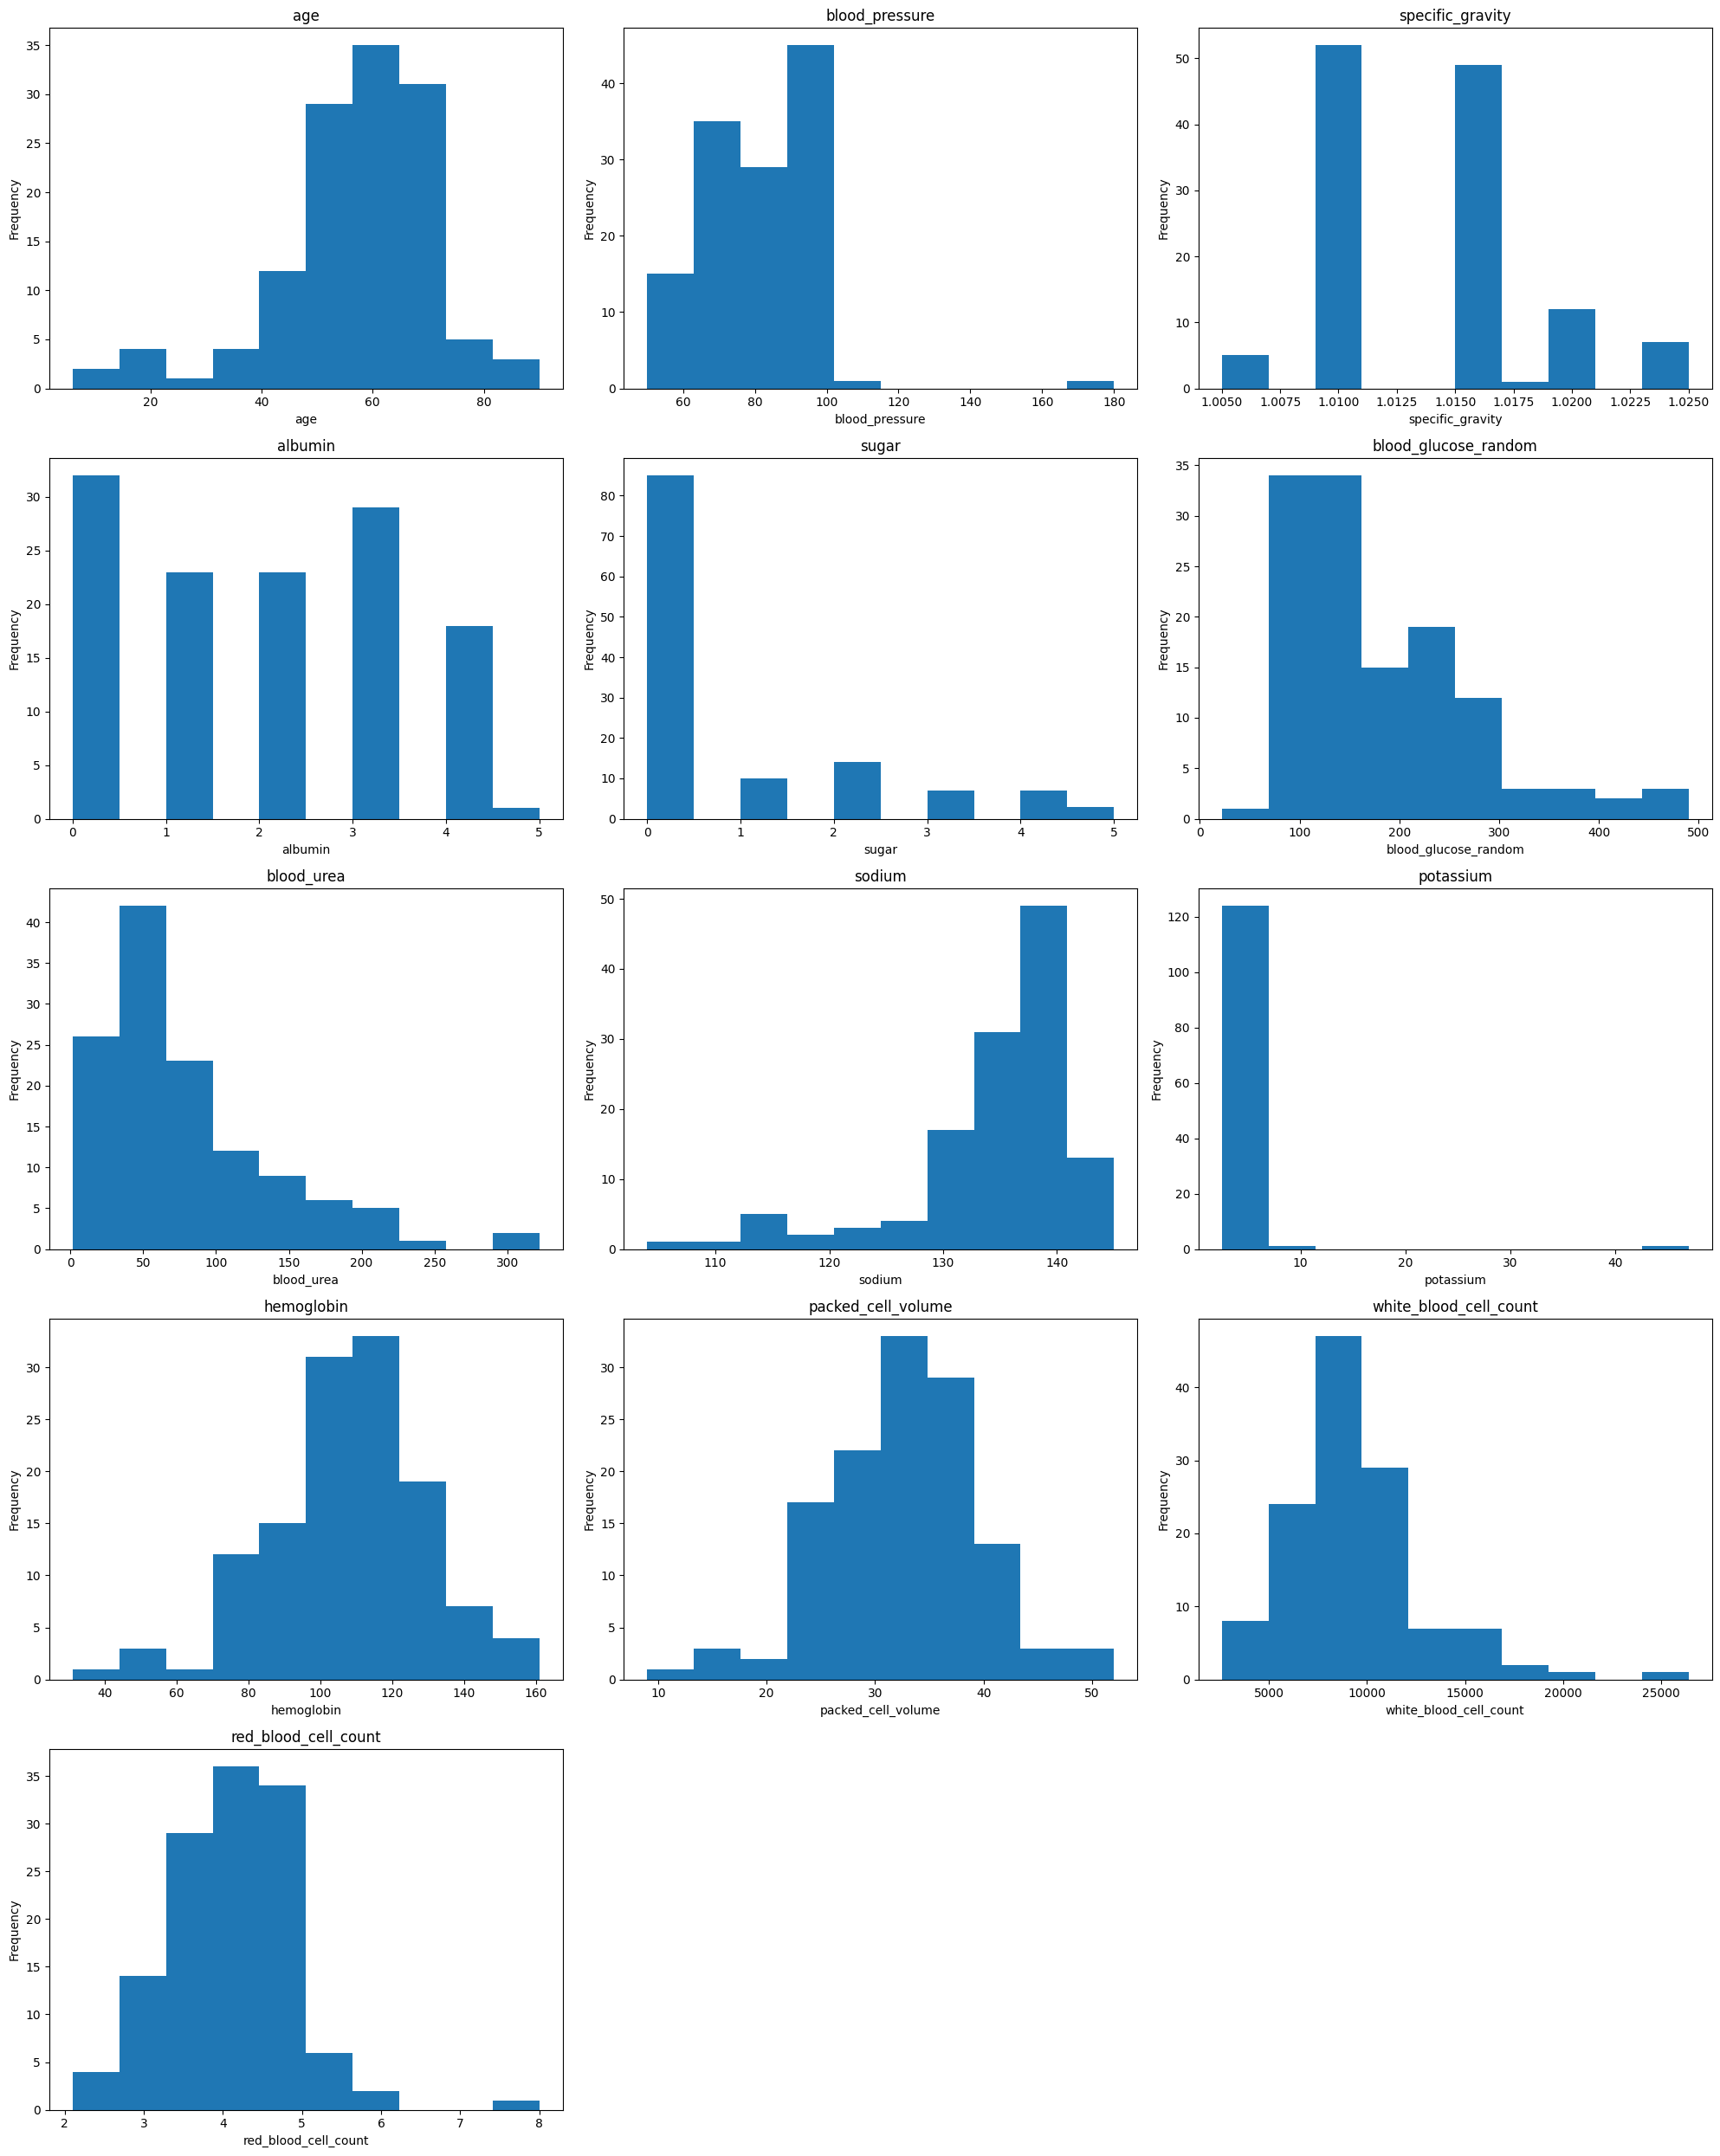

In [380]:
# Dataframe "a" histogrammi
plot_data(df_a)

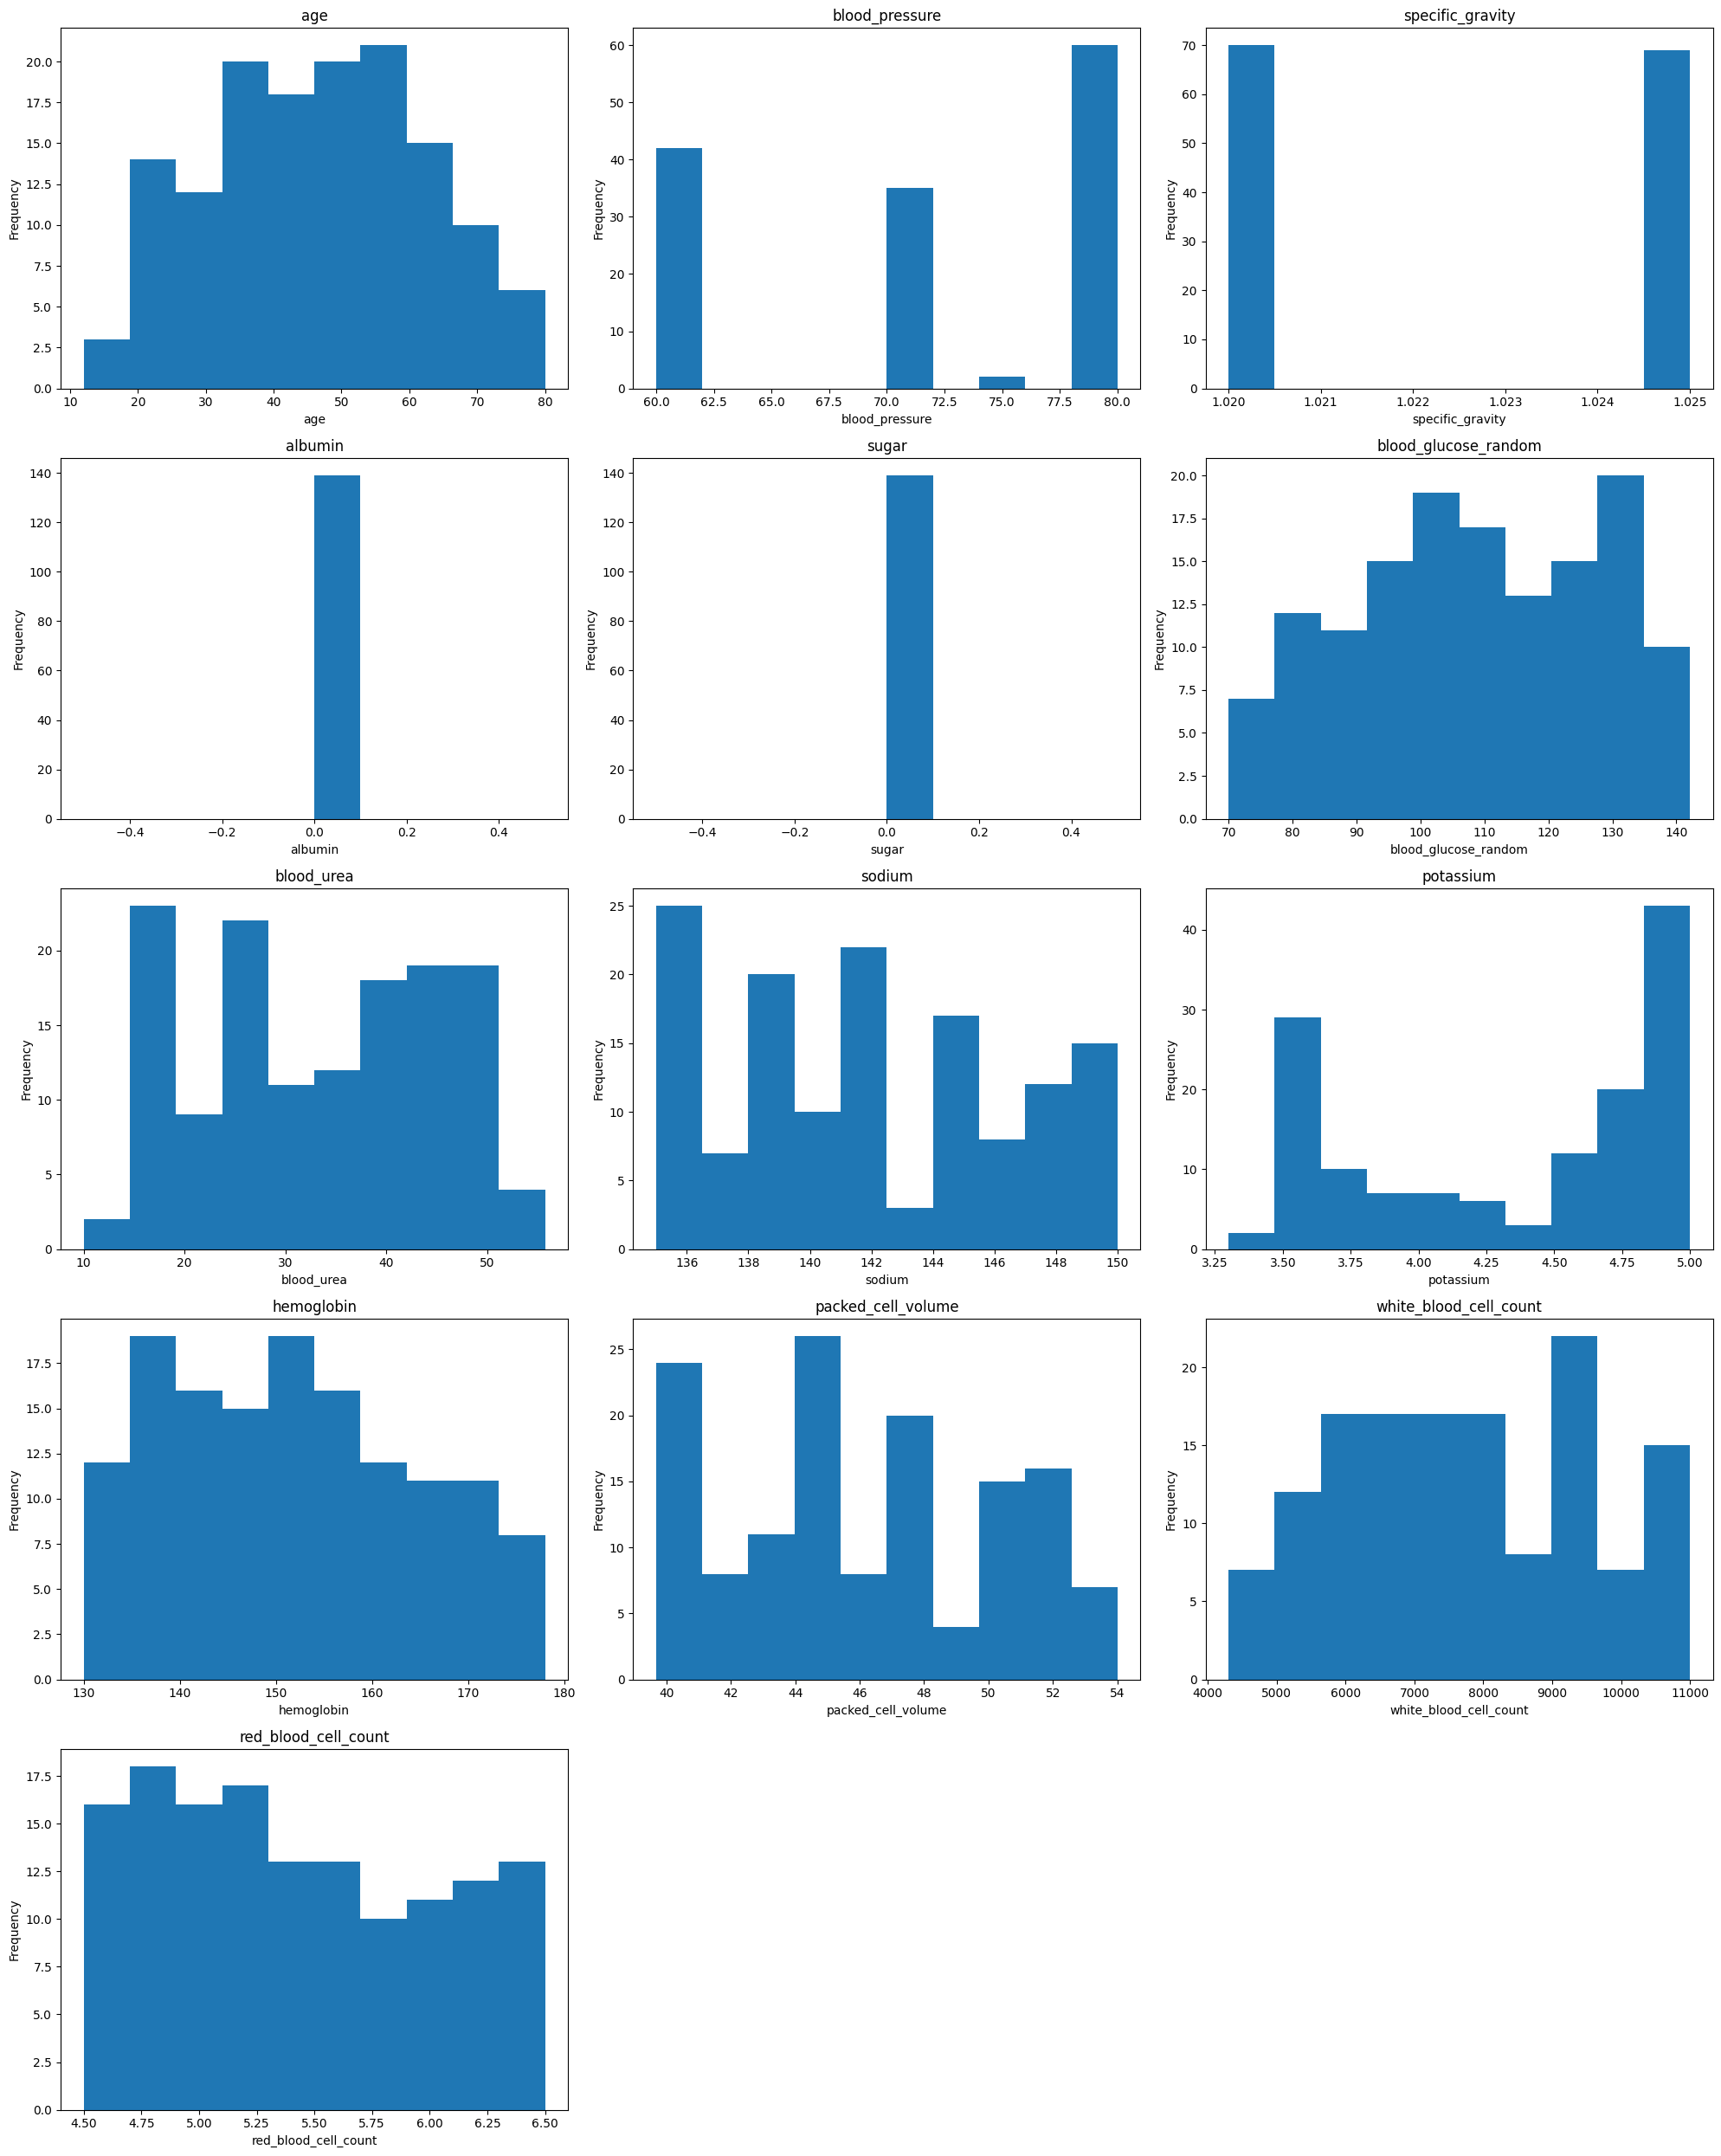

In [381]:
# Dataframe "c" histogrammi
plot_data(df_c)

In [382]:
# Funktio correlaatio matriksin tekoon ja heatmap

import matplotlib.pyplot as plt

def plot_correlation_matrix_matplotlib(df, title):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    corr = df[numeric_cols].corr()
    print(f"Correlation matrix for {title}:\n", corr)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title(f'Correlation matrix heatmap for {title}')
    plt.show()

Correlation matrix for Dataframe (a):
                              age  blood_pressure  specific_gravity   albumin  \
age                     1.000000        0.066683         -0.008287 -0.015353   
blood_pressure          0.066683        1.000000          0.103561  0.025275   
specific_gravity       -0.008287        0.103561          1.000000 -0.070963   
albumin                -0.015353        0.025275         -0.070963  1.000000   
sugar                   0.143637        0.182771         -0.025501  0.115618   
blood_glucose_random    0.201624        0.036711         -0.076234  0.083630   
blood_urea              0.020184        0.067033         -0.042272  0.426327   
sodium                 -0.025543        0.140154          0.132493 -0.216467   
potassium              -0.005175        0.066084          0.042630  0.170867   
hemoglobin              0.003760       -0.115363          0.107848 -0.378211   
packed_cell_volume     -0.032217       -0.120094          0.098780 -0.336223   
w

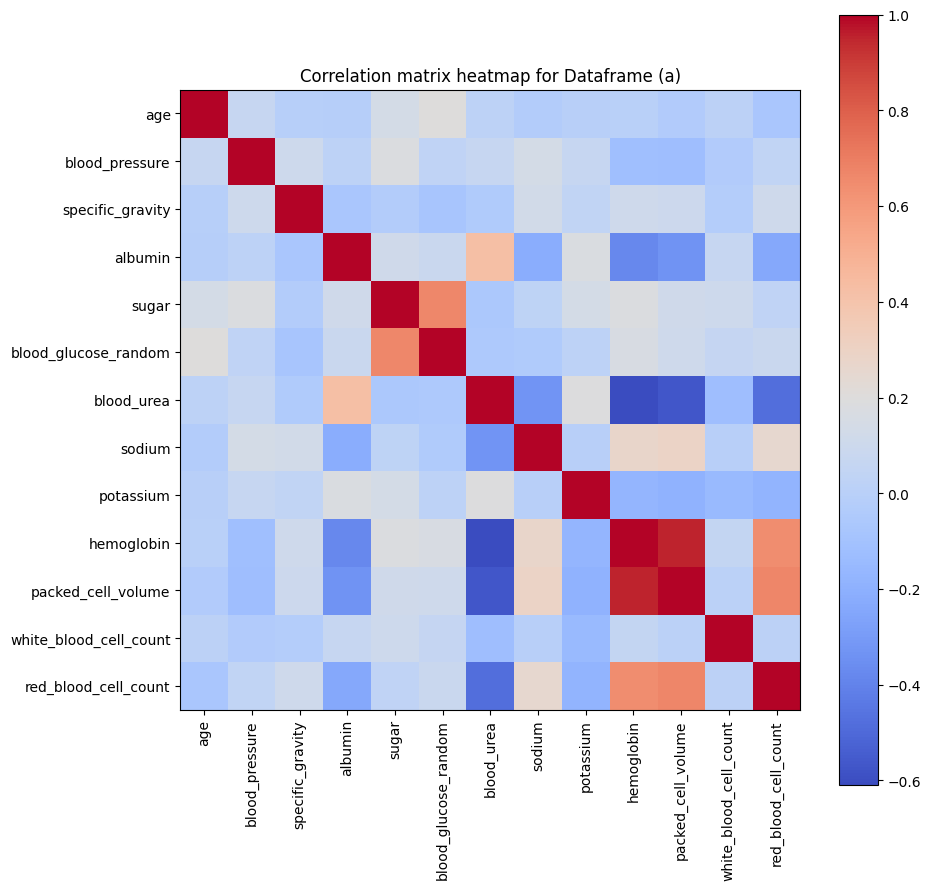

In [383]:
# Dataframe "a" correlation matrix ja heatmap
plot_correlation_matrix_matplotlib(df_a, "Dataframe (a)")

Correlation matrix for Dataframe (c):
                              age  blood_pressure  specific_gravity  albumin  \
age                     1.000000       -0.072757         -0.092814      NaN   
blood_pressure         -0.072757        1.000000          0.076135      NaN   
specific_gravity       -0.092814        0.076135          1.000000      NaN   
albumin                      NaN             NaN               NaN      NaN   
sugar                        NaN             NaN               NaN      NaN   
blood_glucose_random    0.108365       -0.039596         -0.009829      NaN   
blood_urea              0.078872       -0.108135         -0.018737      NaN   
sodium                  0.105948       -0.099754         -0.028067      NaN   
potassium              -0.091926       -0.057867          0.071163      NaN   
hemoglobin              0.085749        0.143135          0.049480      NaN   
packed_cell_volume      0.006532       -0.016096          0.004397      NaN   
white_blood_c

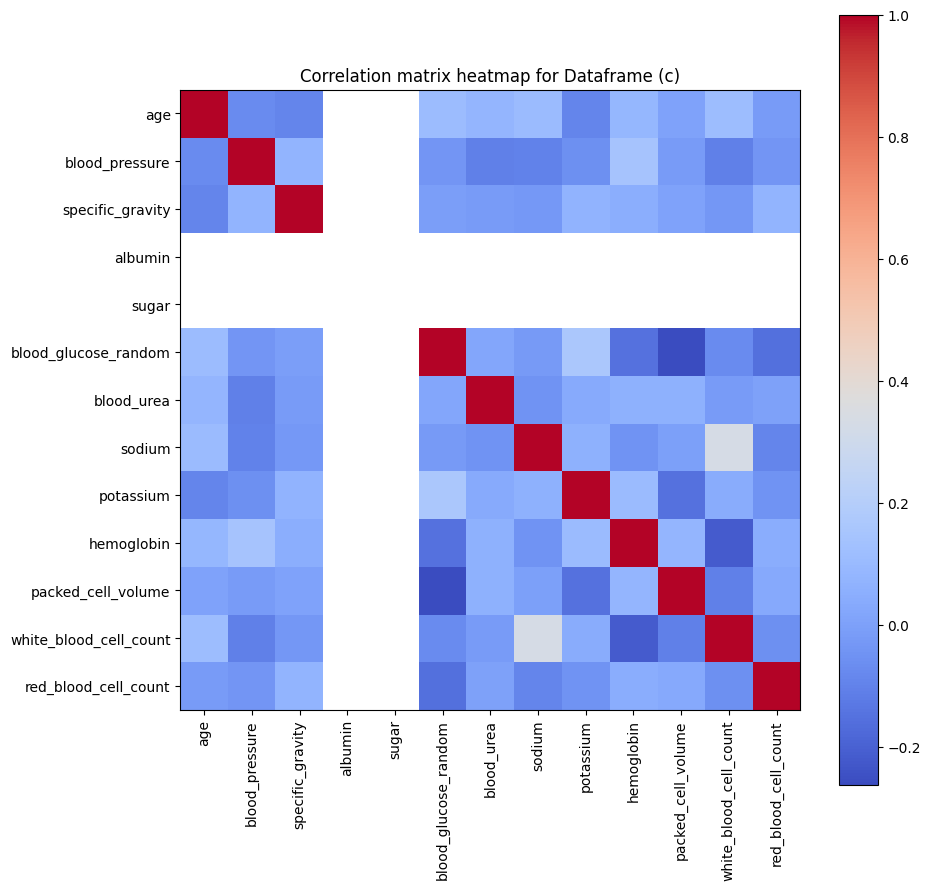

In [384]:
# Dataframe "c" correlation matrix ja heatmap
plot_correlation_matrix_matplotlib(df_c, "Dataframe (c)")